# Face clustering Visualization

In [1]:
import os
import subprocess
import matplotlib
from matplotlib.pyplot import figure
from datetime import datetime
import time as tm
from PIL import Image
import cv2
import pickle
import random
import face_recognition
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import telegram

In [2]:
keys = open('../telegram_keys','r')
token,chat_id=keys.read().split(',')
def ping_telegram(text):
    import telegram
    bot = telegram.Bot(token=token)
    bot.send_message(chat_id=chat_id[:-1], text = text )

In [3]:
def loadPickle(filename):
    infile = open(filename,'rb')
    return pickle.load(infile)

def storePickle(filename, data):
    file = open(filename,'wb')
    pickle.dump(data, file)
    file.close() 

## Face encodings using <a href="https://github.com/ageitgey/face_recognition">face_recognition</a>

In [4]:
def sec2HMS(seconds):
    #seconds = int(seconds)
    return tm.strftime('%H:%M:%S', tm.gmtime(seconds))

In [5]:
def getFaceEncodings(vid_path, dirName, interval=60, model = 'hog', store=False):
    """ Returns 129D encodings for each face present in the video
        First 128 are the face encodings and the last value is the time.
        
       :param interval: (in seconds) frame interval to skip and look for faces
       :param model: 'hog' is less accurate but faster compared to 'cnn'
       :param store: if True, stores the faces in directory specified by dirName """
    vidcap = cv2.VideoCapture(vid_path)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    print("FPS of the video: {}".format(fps))
    allEncodings = [] #Dict mapping face jpg to its encodings
    n_frame = 0 # no. of frame being processed
    if not os.path.exists(dirName):
        os.mkdir(dirName)
    success, frame = vidcap.read()
    while success:
        rgb = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        time = int(n_frame/fps)
        #print(time)
        bboxes = face_recognition.face_locations(rgb,model=model)
        encodings = face_recognition.face_encodings(rgb,bboxes)
        for i,bbox in enumerate(bboxes): #for each found face in the frame
            top,right,bottom,left = bbox[0],bbox[1],bbox[2],bbox[3]
            face_img = frame[top:bottom, left:right]
            
            if store:
                filename = dirName+"/t"+sec2HMS(n_frame/fps)+"f"+str(i)+".jpg"
                cv2.imwrite(filename, face_img)
                
            encod_with_time = np.append(encodings[i],time)
            allEncodings.append(encod_with_time)
            
        n_frame += interval            
        vidcap.set(cv2.CAP_PROP_POS_FRAMES,n_frame)
        success, frame = vidcap.read()    
    #Pickling data as a binary stream 
    file = open(dirName+'/faceEncodingsPickle','wb')
    pickle.dump(allEncodings, file)
    file.close()
    return allEncodings

In [ ]:
try:
    encodings = getFaceEncodings("../data/2006-2Hours.mp4",dirName="2006-2Hours",store=True)
except:
    ping_telegram("ERROR")
ping_telegram('Face encodings for 2 hours are ready')

In [ ]:
try:
    encodings = getFaceEncodings("../data/2006-01-02_0000_US_00001057_V11_M2_VHS10_H4_JA.mp4",dirName="2006-8Hours",store=False)
except:
    ping_telegram("ERROR")
ping_telegram('Face encodings for 8 hours are ready')

In [155]:
encodings = np.array(encodings)
print(encodings.shape)
print("First 128 are encodings, the last value stores the time")

(72, 129)
First 128 are encodings, the last value stores the time


## Unclustered faces visualization using time for color gradient

In [124]:
#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
import plotly
file = open('plotly_key','r')
plotly_key = (file.read()[:-1])
plotly.tools.set_credentials_file(username='eonr', api_key=plotly_key)
import plotly.plotly as py
import plotly.graph_objs as go

In [157]:
data = StandardScaler().fit_transform(encodings[:,:-1]) #Leaving out time for PCA
pca = PCA(n_components=2)
encodings2D = pca.fit_transform(data)
print(encodings2D.shape)

(72, 2)


In [158]:
x = encodings2D[:,0]
y = encodings2D[:,1]
z = encodings[:,-1] #time
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=-z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

In [159]:
layout = go.Layout( scene = dict(
                    xaxis = dict(
                        title='feature-1'),
                    yaxis = dict(
                        title='feature-2'),
                    zaxis = dict(
                        title='Time'),),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    
)

In [ ]:
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='faces-SAAClip-4 minutes')

In [ ]:
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='faces-2006-2 hours')

In [ ]:
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='faces-2006-8 hours')

## Clustered faces visualization

In [6]:
def findFaces(image_path, model="cnn"):
    """Returns b-boxes and encodings of all faces present in the image
    
    :param image: must be in RGB format
    :param model: hog is less accurate but faster compared to cnn

    boxes    : list of bboxes, each a tuple of size 4
    encodings: list of 128-d encodings for each face"""
    im = Image.open(image_path)
    image = face_recognition.load_image_file(image_path)
    width, height = im.size
    boxes = [(0,width,height,0)]
    encodings = face_recognition.face_encodings(image,boxes)
    return boxes, encodings

In [7]:
def HMS2sec(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

In [8]:
def file2encoding(vid_path, dirName, interval=60, model = 'hog', store=False):
    """ Returns 129D encodings for each face present in the video
        First 128 are the face encodings and the last value is the time.
        
       :param interval: (in seconds) frame interval to skip and look for faces
       :param model: 'hog' is less accurate but faster compared to 'cnn'
       :param store: if True, stores the faces in directory specified by dirName """
    vidcap = cv2.VideoCapture(vid_path)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    print("FPS of the video: {}".format(fps))
    allEncodings = {} #Dict mapping face jpg to its encodings
    n_frame = 0 # no. of frame being processed
    if not os.path.exists(dirName):
        os.mkdir(dirName)
    success, frame = vidcap.read()
    while success:
        rgb = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        time = int(n_frame/fps)
        #print(time)
        bboxes = face_recognition.face_locations(rgb,model=model)
        encodings = face_recognition.face_encodings(rgb,bboxes)
        for i,bbox in enumerate(bboxes): #for each found face in the frame
            top,right,bottom,left = bbox[0],bbox[1],bbox[2],bbox[3]
            face_img = frame[top:bottom, left:right]
            
            if store:
                filename = dirName+"/t"+sec2HMS(n_frame/fps)+"f"+str(i)+".jpg"
                cv2.imwrite(filename, face_img)
                
            encod_with_time = np.append(encodings[i],time)
            allEncodings[filename]=(encod_with_time)
            
        n_frame += interval            
        vidcap.set(cv2.CAP_PROP_POS_FRAMES,n_frame)
        success, frame = vidcap.read()    
    #Pickling data as a binary stream 
    file = open(dirName+'/faceEncodingsPickle','wb')
    pickle.dump(allEncodings, file)
    file.close()
    return allEncodings

In [9]:
root = '2006-8hour-imagecluster' #directory to store the encodings, faces and face_clusters in

In [33]:
encodings= file2encoding('../data/2006-01-02_0000_US_00001057_V11_M2_VHS10_H4_JA.mp4',dirName=root,store=True) #TODO - make this "../data/2006-2Hours.mp4"

FPS of the video: 29.97


In [10]:
#Loading pickle
infile = open('faceEncodingsPickle','rb')
encodings = pickle.load(infile)

In [11]:
keys = encodings.keys()
values = np.array(list(encodings.values()))

data = StandardScaler().fit_transform(values[:,:-1]) #Leaving out time for PCA
pca = PCA(n_components=2)
features2D = pca.fit_transform(data)

encodings3D = {}
for i,key in enumerate(keys):
    feature1 = features2D[i,0]
    feature2 = features2D[i,1]
    time = values[i,-1]
    encodings3D[key] = np.array([feature1, feature2, time])

#### Clustering using <a href="https://github.com/elcorto/imagecluster">imagecluster</a>

In [2]:
from imagecluster import main

Using TensorFlow backend.


In [ ]:
try:
    main.main('2006-8hour-imagecluster/',sim=0.7,vis=False)
    ping_telegram('Clustering is done!')
except:
    ping_telegram('Error :(')

In [ ]:
!tree 2006-8hour-imagecluster/imagecluster/clusters

### 2D Scatter plot -> (feature1 and feature2 on y-axis, time on x-axis)

In [53]:
traces = []
fakeroot=root+'/imagecluster/clusters/'
for clusterDir in tqdm(os.listdir(fakeroot)):
    for cluster in os.listdir(fakeroot+clusterDir):
        encodings_ = []
        for image_file in os.listdir(fakeroot+clusterDir+'/'+cluster):
            encodings_.append(encodings3D[root+'/'+image_file])          
        
        encodings_ = np.array(encodings_)
        x = encodings_[:,0]
        y = encodings_[:,1]
        z = encodings_[:,2] #time
        #Generating random color  for this cluster
        #r, g, b = random.sample(range(0, 256), 3)
        #a = random.uniform(0.2,1)
        trace0 = go.Scatter(
            x=z,
            y=x,
            mode='markers',
            name = clusterDir+'/'+cluster+'0',
            marker=dict(
                size=12,
                line=dict(
                color='red',
                width=0.5
                ),
                opacity=0.8
            )
        )
        trace1 = go.Scatter(
            x=z,
            y=y,
            mode='markers',
            name = clusterDir+'/'+cluster+'1',
            marker=dict(
                size=12,
                line=dict(
                color='blue',
                width=0.5
                ),
                opacity=0.8
            )
        )
        traces.append(trace0)
        traces.append(trace1)

100%|██████████| 22/22 [00:02<00:00,  7.39it/s]


In [54]:
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

In [ ]:
fig = go.Figure(data=traces, layout=layout)
py.iplot(fig, filename='8hour-imageclusters_visualized_2D')

In [ ]:
fig = go.Figure(data=traces, layout=layout)
py.iplot(fig, filename='2hour-imageclusters_visualized_2D')

### 3D Scatter plot -> (feature1, feature2, time)

In [50]:
traces = []
fakeroot=root+'/imagecluster/clusters/'
for clusterDir in tqdm(os.listdir(fakeroot)):
    for cluster in os.listdir(fakeroot+clusterDir):
        encodings_ = []
        for image_file in os.listdir(fakeroot+clusterDir+'/'+cluster):
            encodings_.append(encodings3D[root+'/'+image_file])          
        
        encodings_ = np.array(encodings_)
        x = encodings_[:,0]
        y = encodings_[:,1]
        z = encodings_[:,2] #time
        #Generating random color  for this cluster
        r, g, b = random.sample(range(0, 256), 3)
        a = random.uniform(0.2,1)
        trace = go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            name = clusterDir+'/'+cluster,
            marker=dict(
                size=12,
                line=dict(
                color='rgba({}, {}, {}, {})'.format(r,g,b,a),
                width=0.5
                ),
                opacity=0.8
            )
        )
        traces.append(trace)

100%|██████████| 22/22 [00:01<00:00, 14.81it/s]


In [51]:
layout = go.Layout( scene = dict(
                    xaxis = dict(
                        title='feature-1'),
                    yaxis = dict(
                        title='feature-2'),
                    zaxis = dict(
                        title='Time'),),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    
)

In [ ]:
fig = go.Figure(data=traces, layout=layout)
py.iplot(fig, filename='8hour-imageclusters_visualized_3D')

In [190]:
ping_telegram('8 hours done!')

In [ ]:
fig = go.Figure(data=traces, layout=layout)
py.iplot(fig, filename='2hour-imageclusters_visualized')

In [ ]:
fig = go.Figure(data=traces, layout=layout)
py.iplot(fig, filename='imageclusters_visualized')

## Black frames

In [9]:
def findBlacks(vid_path):
    times = []
    blackFrames = []
    vidcap = cv2.VideoCapture(vid_path)
    n_frame = 0 # no. of frame being processed
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    print("FPS of the video: {}".format(fps))
    success, frame = vidcap.read()
    printed = 0
    while success:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        time = int(n_frame/fps)
        if(time%1000==0):
            if (printed==0):
                print('Time: '+str(time))
                printed=1
        else:
            printed=0
        time=sec2HMS(time)
        if(np.max(frame) < 20):
            print('Black frame found at '+time)
            times.append(time)
            blackFrames.append(1)
        else:
            blackFrames.append(0)
        n_frame+=1
        success, frame = vidcap.read()
    return times,blackFrames

In [166]:
def getStreak(array, radius):
    newarray = []
    for i in range(radius,len(array)-radius):
        newarray.append(sum(array[i-radius:i+radius]))
    return newarray

In [ ]:
times,blackFrames = findBlacks('../data/2006-01-02_0000_US_00001057_V11_M2_VHS10_H4_JA.mp4')

In [301]:
times,blackFrames = loadPickle('2006-8hour-blacks-tuple')

In [302]:
count=0
for x in blackFrames:
    if(x==1):
        count+=1
print('Percentage of black frames: '+str(count*100/len(blackFrames)))

Percentage of black frames: 0.1507751330418573


In [303]:
#Binning
localBlacks=[]
binsize=100
for i in range(len(blackFrames[:1-binsize])):
    summ=0
    for j in range(binsize):
        summ+=blackFrames[i+j]
    localBlacks.append(summ)
topBlacks = sorted(range(len(localBlacks)), key=lambda i: localBlacks[i])[-100:]

In [304]:
totalFrames=len(localBlacks)
xaxis = [datetime.strptime(sec2HMS(secs),"%H:%M:%S") for secs in range(totalFrames)]

In [ ]:
HMS2sec('00:59:36')*30

In [351]:
sec2HMS((80000+7500+2000+500)/30)

'00:50:00'

In [314]:
blackStreak = getStreak(blackFrames,60)

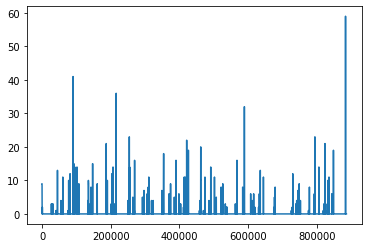

In [315]:
plt.plot(blackStreak)
plt.show()

In [145]:
import collections
from collections import Counter
timedict = (Counter(times))

In [185]:
x = []
y = []
for HMS in timedict:
    x.append(datetime.strptime(HMS,"%H:%M:%S"))
    y.append(timedict[HMS])

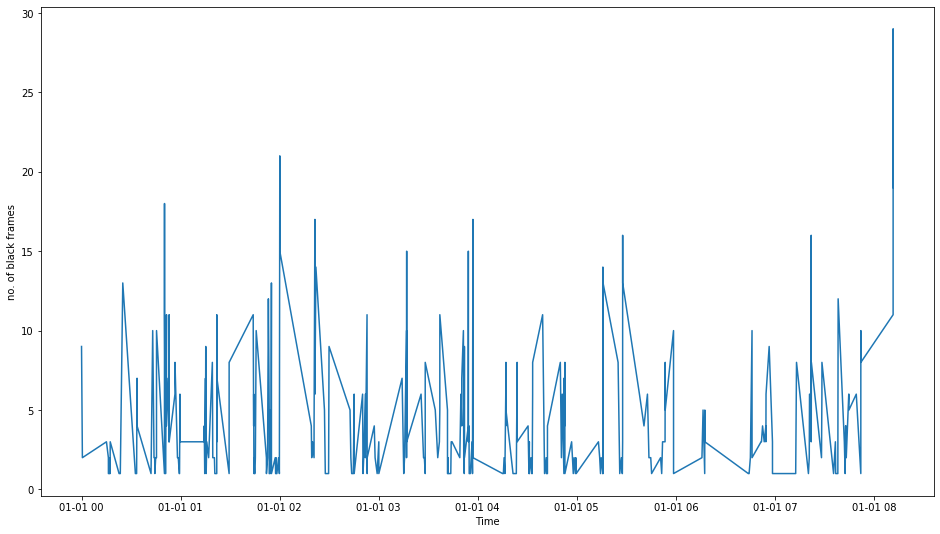

In [189]:
plt.plot(x,y)
plt.rcParams["figure.figsize"] = [16,9]
plt.xlabel('Time')
plt.ylabel('no. of black frames')
plt.show()

In [ ]:
 (sorted(timedict.items(), key = 
             lambda kv:(kv[1], kv[0])))  

In [ ]:
for x in range(len(timedict.keys())):
    if timedict

# Plain face inference

In [180]:
def classifyFaces(folder, minimum_frequency=0):
    """Returns a list of 2d tuples. Each tuple contains
       the time of appearance of the face and its class.
       onehot - dict mapping "readable" class names to their
       number value"""
    faces = []
    classes = 0
    onehot = {}
    for cluster_with_size in os.listdir(folder):
        size = int(cluster_with_size.split('_')[2])
        if(size < minimum_frequency):
            continue
        #print('size: '+str(size))
        for cluster_n in os.listdir(folder+'/'+cluster_with_size):
            n = int(cluster_n.split('_')[1])
            #print(n)
            face_class = str(size)+'_'+str(n)
            onehot[face_class] = classes
            classes+=1
            for face in os.listdir(folder+'/'+cluster_with_size+'/'+cluster_n):
                face_time = face[1:9]
                faces.append((face_time,face_class))
    return faces, onehot

In [181]:
folder = '2006-8hour-imagecluster/imagecluster/clusters'
faces, onehot = classifyFaces(folder)
onehot['-1'] = -1
faces = sorted(faces, key = lambda x: HMS2sec(x[0]))
faces_onehotted = [(x[0],onehot[x[1]]) for x in faces]

In [182]:
faces[10:20]

[('01:02:35', '6_5'),
 ('01:02:37', '9_3'),
 ('01:02:41', '6_5'),
 ('01:02:45', '9_3'),
 ('01:02:47', '6_5'),
 ('01:02:49', '9_3'),
 ('01:02:51', '6_5'),
 ('01:04:05', '9_3'),
 ('01:04:07', '9_3'),
 ('01:04:09', '9_3')]

In [183]:
faces_onehotted[10:20]

[('01:02:35', 179),
 ('01:02:37', 196),
 ('01:02:41', 179),
 ('01:02:45', 196),
 ('01:02:47', 179),
 ('01:02:49', 196),
 ('01:02:51', 179),
 ('01:04:05', 196),
 ('01:04:07', 196),
 ('01:04:09', 196)]

## Face vs no-face

In [144]:
def readFaces(folder):
    faces = []
    for img in sorted(os.listdir(folder)):
        time = img[1:9]
        faces.append((time,1))
    return faces

In [145]:
faces = readFaces('2006-8hour-OLDimagecluster')

In [147]:
faces[10:20]

[('00:00:40', 1),
 ('00:00:42', 1),
 ('00:00:44', 1),
 ('00:01:18', 1),
 ('00:01:20', 1),
 ('00:01:22', 1),
 ('00:01:24', 1),
 ('00:01:26', 1),
 ('00:01:28', 1),
 ('00:01:30', 1)]

In [184]:
def addEmptyFaces(faces, skip_gap):
    """Modifies faces dict to include timestamps where no faces are present
       '-1' is the value assigned to these.
       :skip_gap: 'interval' parameter given in file2encoding() function (in seconds)"""
    min_time = HMS2sec(faces[0][0])
    max_time = HMS2sec(faces[-1][0])
    curr_time = min_time
    faces_empty = []
    counter = 0
    
    while (curr_time < max_time):
        if(HMS2sec(faces[counter][0]) > curr_time): #No face found at this time
            faces_empty.append((sec2HMS(curr_time), '-1'))
        else:                              #Face was already marked at this time
            faces_empty.append(faces[counter])
            counter+=1
        curr_time += skip_gap
    return faces_empty

In [185]:
faces_empty = addEmptyFaces(faces, 2)
#faces_empty_oh = [(x[0],onehot[x[1]]) for x in faces_empty] #onehotted

In [186]:
faces_empty[10:20]

[('01:02:35', '6_5'),
 ('01:02:37', '9_3'),
 ('01:02:39', '-1'),
 ('01:02:41', '6_5'),
 ('01:02:43', '-1'),
 ('01:02:45', '9_3'),
 ('01:02:47', '6_5'),
 ('01:02:49', '9_3'),
 ('01:02:51', '6_5'),
 ('01:02:53', '-1')]

In [151]:
isFace = [int(x[1]!='-1') for x in faces_empty]
isNotFace = [1-x for x in isFace]

In [175]:
radius = 30
streak = getStreak(isNotFace, radius)
min_x = HMS2sec(faces_empty[0][0])
max_x = HMS2sec(faces_empty[-1][0])
xaxis = np.arange(min_x+radius, max_x-radius+1, 2)
#trace1 = go.Scatter(x = xaxis, y = isFace)
trace2 = go.Scatter(x = xaxis, y = streak, mode='lines',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 4))
py.iplot([trace2], filename='Face or not')
# plt.step(xaxis, isFace)
# plt.show()
# plt.close()

In [233]:
sec2HMS(14222)

'03:57:02'

## Most common face in the last x seconds

In [295]:
def faceTrends(faces, interval, overlapping = False, join_consecutive = False):
    #TODO- make empty entries for each second or two.
    #      Don't count these for face_count
    import operator
    trending_face = faces[0][1] #First face's class
    trendy_faces = {faces[0][0]:trending_face} 
    
    if overlapping:
        skip=1
    else:
        skip=interval
        
    for x in range(0, len(faces)-interval, skip):
        face_count = {} #Keeps count of no. of instances of each face_class
        
        for face in faces[x:x+interval]:
            curr_time = face[0]
            curr_face = face[1]
            if curr_face == '-1':
                continue
                
            if curr_face in face_count:
                face_count[curr_face] += 1
            else:
                face_count[curr_face] = 1
                
        if face_count: # if face_count is not empty
            max_face_in_interval = max(face_count.items(), key=operator.itemgetter(1))[0]
        else:
            max_face_in_interval = '-1'
        if join_consecutive:
            if(max_face_in_interval!=trending_face):
                trending_face = max_face_in_interval
                trendy_faces[curr_time] = trending_face
        else:
            trending_face = max_face_in_interval
            trendy_faces[curr_time] = trending_face

#             if (face_count[curr_face]>face_count[trending_face]):
#                 trending_face = curr_face
#                 curr_time = face[0]
#                 trendy_faces[curr_time] = curr_face
    return trendy_faces          

In [ ]:
def faceTrendsDuration(faces, interval, overlapping = False, join_consecutive = False):
    #TODO- make empty entries for each second or two.
    #      Don't count these for face_count
    trending_face = faces[0][1] #First face's class
    trendy_faces = {faces[0][0]:trending_face} 
    
    if overlapping:
        skip=1
    else:
        skip=interval
        
    for x in range(0, len(faces)-interval, skip):
        face_count = {} #Keeps count of no. of instances of each face_class
        
        for face in faces[x:x+interval]:
            curr_time = face[0]
            curr_face = face[1]
            if curr_face == '-1':
                continue
                
            if curr_face in face_count:
                face_count[curr_face] = (face_count[curr_face][0],curr_time)
            else:
                face_count[curr_face] = (curr_time, curr_time)
                
        if face_count: # if face_count is not empty
            max_face_in_interval = sorted(list(face_count.keys()), key =(lambda key: HMS2sec(face_count[key][1]) - HMS2sec(face_count[key][0])),reverse=True)[:5]
        else:
            max_face_in_interval = '-1'
        if join_consecutive:
            if(max_face_in_interval!=trending_face):
                trending_face = max_face_in_interval
                trendy_faces[curr_time] = trending_face
        else:
            trending_face = max_face_in_interval
            trendy_faces[curr_time] = trending_face

#             if (face_count[curr_face]>face_count[trending_face]):
#                 trending_face = curr_face
#                 curr_time = face[0]
#                 trendy_faces[curr_time] = curr_face
    return trendy_faces          

In [296]:
sorted(a,reverse=True)

[4, 3, 2, 1]

In [299]:
trends = faceTrends(faces_empty,100,False,False)

In [300]:
for x in trends.items():
    print(x)

('01:02:15', '44_0')
('01:05:33', ['6_5', '9_3', '7_8', '44_0', '2_75'])
('01:08:53', ['10_0', '32_0', '44_0', '2_31', '7_8'])
('01:12:13', ['6_10', '6_8', '5_2', '2_67', '2_80'])
('01:15:33', ['10_0', '32_0', '5_4', '9_1', '2_10'])
('01:18:46', ['10_3', '8_2', '7_1', '5_0', '5_13'])
('01:22:12', ['2_64', '2_59', '3_9', '5_13', '4_10'])
('01:25:31', ['5_9', '5_14', '4_20', '2_85', '3_28'])
('01:28:53', ['6_9', '4_13', '2_24', '7_4', '3_34'])
('01:32:13', ['44_0', '2_91', '3_21', '14_0', '7_6'])
('01:35:33', ['32_0', '10_2', '9_1', '5_4', '44_0'])
('01:38:53', ['14_0', '44_0', '14_2', '14_1', '6_3'])
('01:42:12', ['44_0', '40_0', '4_12', '19_0', '18_0'])
('01:45:33', ['6_4', '9_2', '3_21'])
('01:48:53', ['5_6', '13_0', '43_0', '5_1', '4_3'])
('01:52:13', ['14_0', '43_0', '8_0', '13_0', '44_0'])
('01:55:33', ['3_5', '3_3', '2_91', '3_21', '3_0'])
('01:58:53', ['4_16', '13_1', '44_0', '4_17', '9_2'])
('02:02:13', ['12_0', '29_0', '3_30', '3_22', '2_36'])
('02:05:33', ['29_0', '16_0', '18_

In [ ]:
#TODO - instead of face count - try face distribution in an interval ^

In [ ]:
#TODO - black frames inference
#TODO - check contiguous shows
#TODO - Slides

## Better face clustering

In [247]:
from pyfacy import face_clust

In [ ]:
mdl = face_clust.Face_Clust_Algorithm('./2006-8hour-OLDimagecluster/')
mdl.load_faces()

In [253]:
#!mkdir pyfacy_all
mdl.save_faces('./pyfacy_all')